# Analysis of IMDB Movie Dataset

For EdX Course
Python for Data Science (Week 6 Mini Project)

Full analysis in file `imdb-movie-dataset-analysis.py`

## Import libraries

In [12]:
## ========================================================================= ## 
## import libraries
## ========================================================================= ##

import requests
import io
import zipfile
import os
import urllib.parse
import re   ## for regular expressions
from itertools import chain  ## for chain, similar to R's unlist (flatten lists)
import collections   ## for Counters (used in frequency tables, for example)
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
%matplotlib inline


## Download and extract data

For reproducibility, the data is downloaded in the code snipped below.

In [2]:
## ========================================================================= ##
## download and extract zip
## ========================================================================= ##

## define url and filename, as well as target path:
url_base = 'http://files.grouplens.org/datasets/movielens/'
filename = 'ml-20m.zip'
url = urllib.parse.urljoin(url_base, filename)
path_dat = './data'

## download (commented out in order not to repeat it every time):
r = requests.get(url, allow_redirects=True)
open(filename, 'wb').write(r.content)

## check download:
os.getcwd()
os.listdir()
 
## unzip:
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall(path_dat)
zip_ref.close()

## Load all necessary data files

In [4]:
## ========================================================================= ##
## Load data files
## ========================================================================= ##

dat_movies = pd.read_csv(
    os.path.join(path_dat, 'ml-20m/movies.csv'), 
    sep = ',')

print(dat_movies.info())
dat_movies.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
movieId    27278 non-null int64
title      27278 non-null object
genres     27278 non-null object
dtypes: int64(1), object(2)
memory usage: 639.4+ KB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [5]:
dat_ratings = pd.read_csv(
    os.path.join(path_dat, 'ml-20m/ratings.csv'), 
    sep = ',')

print(dat_ratings.info())
dat_ratings.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 610.4 MB
None


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676


## Data prep

In [7]:
# ========================================================================= ##
## data prep
## ========================================================================= ##

## possible research questions:
## * what is the relationship of movie complexity 
##   (as measured by number of genres) and average rating? u-shaped?
## * what is the relationship of genres and average rating? 
##   have different genres different ratings, on average?


## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## aggregate ratings data
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## aggregate ratings data:
## https://stackoverflow.com/questions/38935541/dplyr-summarize-equivalent-in-pandas
dat_ratings_agg = dat_ratings \
    .groupby('movieId') \
    .agg({'rating': ['size', 'min', 'max', 'mean', 'std'], 
         'timestamp': ['min', 'max', 'mean', 'std']})
#dat_ratings_agg.head(2)

## rename columns:
dat_ratings_agg.columns = ['_'.join(col) \
                           for col in dat_ratings_agg.columns]
#dat_ratings_agg.head(2)

## add correct timestamp column (after aggregation, 
## as they cannot be aggregated like numerical values):
dat_ratings['parsed_time'] = pd.to_datetime(
    dat_ratings['timestamp'], unit='s')
dat_ratings_agg['parsed_time_min'] = pd.to_datetime(
    dat_ratings_agg['timestamp_min'], unit='s')
dat_ratings_agg['parsed_time_max'] = pd.to_datetime(
    dat_ratings_agg['timestamp_max'], unit='s')
dat_ratings_agg['parsed_time_mean'] = pd.to_datetime(
    dat_ratings_agg['timestamp_mean'], unit='s')
dat_ratings_agg.head(2)


,rating_size,rating_min,rating_max,rating_mean,rating_std,timestamp_min,timestamp_max,timestamp_mean,timestamp_std,parsed_time_min,parsed_time_max,parsed_time_mean
movieId,,,,,,,,,,,,
1,49695,0.5,5.0,3.921240,0.889012,822873600,1427745477,1.052654e+09,1.741543e+08,1996-01-29,2015-03-30 19:57:57,2003-05-11 11:54:58.862984
2,22243,0.5,5.0,3.211977,0.951150,822873600,1427763075,1.037616e+09,1.754514e+08,1996-01-29,2015-03-31 00:51:15,2002-11-18 10:44:55.644158


In [8]:

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## merge data files into one wide file
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## merge data files into one wide file for analysis by movie:
dat_raw = pd.merge(
    left = dat_movies,
    right = dat_ratings_agg,
    how = 'left',
    on = 'movieId')

dat_raw.head(2)


,movieId,title,genres,rating_size,rating_min,rating_max,rating_mean,rating_std,timestamp_min,timestamp_max,timestamp_mean,timestamp_std,parsed_time_min,parsed_time_max,parsed_time_mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,49695.0,0.5,5.0,3.921240,0.889012,822873600.0,1.427745e+09,1.052654e+09,1.741543e+08,1996-01-29,2015-03-30 19:57:57,2003-05-11 11:54:58.862984
1,2,Jumanji (1995),Adventure|Children|Fantasy,22243.0,0.5,5.0,3.211977,0.951150,822873600.0,1.427763e+09,1.037616e+09,1.754514e+08,1996-01-29,2015-03-31 00:51:15,2002-11-18 10:44:55.644158


In [10]:

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## add measurement for movie complexity
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## add measurement for movie complexity:
dat_raw['complexity'] = dat_raw['genres'] \
    .str.split('|') \
    .apply(lambda x: len(x)) \
    .astype(float)


## exclude movies that have no genres listed:
## '(no genres listed)' --> None
#dat_raw['complexity'] = None if (dat_raw['genres'] == '(no genres listed)') else dat_raw['complexity']
dat_raw['complexity'] = np.where(dat_raw['genres'] == '(no genres listed)', 
                                 None,
                                dat_raw['complexity'])

## turns 'complexity' into type 'object' again...
dat_raw['complexity'] = dat_raw['complexity'].astype(float)

dat_raw.head(5)

,movieId,title,genres,rating_size,rating_min,rating_max,rating_mean,rating_std,timestamp_min,timestamp_max,timestamp_mean,timestamp_std,parsed_time_min,parsed_time_max,parsed_time_mean,complexity
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,49695.0,0.5,5.0,3.921240,0.889012,822873600.0,1.427745e+09,1.052654e+09,1.741543e+08,1996-01-29 00:00:00,2015-03-30 19:57:57,2003-05-11 11:54:58.862984,5.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,22243.0,0.5,5.0,3.211977,0.951150,822873600.0,1.427763e+09,1.037616e+09,1.754514e+08,1996-01-29 00:00:00,2015-03-31 00:51:15,2002-11-18 10:44:55.644158,3.0
2,3,Grumpier Old Men (1995),Comedy|Romance,12735.0,0.5,5.0,3.151040,1.006642,823185228.0,1.427394e+09,9.596480e+08,1.404126e+08,1996-02-01 14:33:48,2015-03-26 18:25:06,2000-05-30 00:53:39.163329,2.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2756.0,0.5,5.0,2.861393,1.095702,823185225.0,1.427061e+09,9.242144e+08,1.135404e+08,1996-02-01 14:33:45,2015-03-22 21:45:09,1999-04-15 22:13:31.009797,3.0
4,5,Father of the Bride Part II (1995),Comedy,12161.0,0.5,5.0,3.064592,0.982140,823185224.0,1.427768e+09,9.620161e+08,1.606569e+08,1996-02-01 14:33:44,2015-03-31 02:16:35,2000-06-26 10:41:25.413371,1.0


In [11]:
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## add is_genre attributes for most common genres
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## get list of different genres:
tmp = dat_raw['genres'] \
    .str.split('|')

genres_nonunique = list(chain.from_iterable(tmp))

## make frequency table:
# import collections
genre_counter = collections.Counter(genres_nonunique)

## create indicator column for each genre:
genre_inds = []
for i in genre_counter.keys():
    #print('creating indicator for key', i, ':')
    this_ind_name = 'is_' + re.sub('[-\(\) ]', '', i).lower()
    genre_inds.append(this_ind_name)
    #print(this_ind_name)
    dat_raw[this_ind_name] = dat_raw['genres'].str.contains(i).astype(int)

## make dictionary of genre_inds: genre_names:
genre_dict = dict(zip(genre_inds, genre_counter.keys()))
genre_dict


/Users/ingonader/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


{'is_adventure': 'Adventure',
 'is_animation': 'Animation',
 'is_children': 'Children',
 'is_comedy': 'Comedy',
 'is_fantasy': 'Fantasy',
 'is_romance': 'Romance',
 'is_drama': 'Drama',
 'is_action': 'Action',
 'is_crime': 'Crime',
 'is_thriller': 'Thriller',
 'is_horror': 'Horror',
 'is_mystery': 'Mystery',
 'is_scifi': 'Sci-Fi',
 'is_imax': 'IMAX',
 'is_documentary': 'Documentary',
 'is_war': 'War',
 'is_musical': 'Musical',
 'is_western': 'Western',
 'is_filmnoir': 'Film-Noir',
 'is_nogenreslisted': '(no genres listed)'}

## Data exploration

### Univariate data exploration

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27278 entries, 0 to 27277
Data columns (total 36 columns):
movieId              27278 non-null int64
title                27278 non-null object
genres               27278 non-null object
rating_size          26744 non-null float64
rating_min           26744 non-null float64
rating_max           26744 non-null float64
rating_mean          26744 non-null float64
rating_std           22772 non-null float64
timestamp_min        26744 non-null float64
timestamp_max        26744 non-null float64
timestamp_mean       26744 non-null float64
timestamp_std        22772 non-null float64
parsed_time_min      26744 non-null datetime64[ns]
parsed_time_max      26744 non-null datetime64[ns]
parsed_time_mean     26744 non-null datetime64[ns]
complexity           27032 non-null float64
is_adventure         27278 non-null int64
is_animation         27278 non-null int64
is_children          27278 non-null int64
is_comedy            27278 non-null int64
is

/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_bin : Removed 534 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


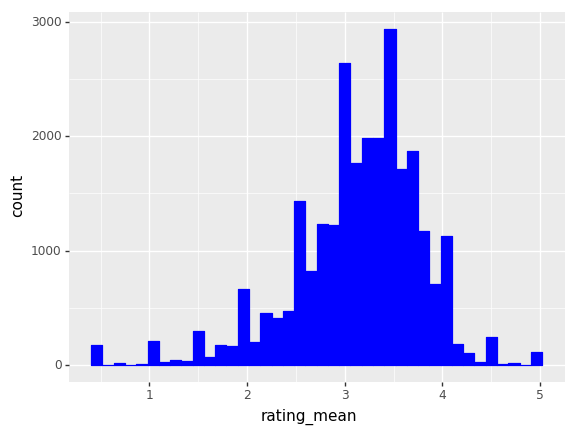

<ggplot: (-9223372036570970045)>

In [15]:
## ========================================================================= ##
## Data exploration
## ========================================================================= ##

print(dat_raw.info())

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## univariate data checks
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## mean ratings:

## check mean ratings (histogram):
ggplot(dat_raw, aes(x = 'rating_mean')) + \
  geom_histogram(bins = 40, color = 'blue', fill = 'blue')



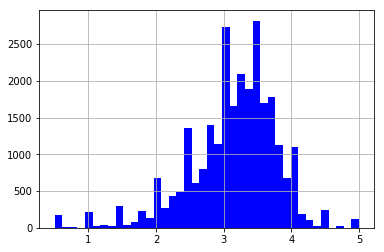

In [16]:
## same plot (histogram) using matplotlib, simple variant:
plt.hist(dat_raw['rating_mean'].dropna().values, 40, density = False, facecolor = 'blue')
plt.grid(True)
plt.show()

/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_count : Removed 246 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


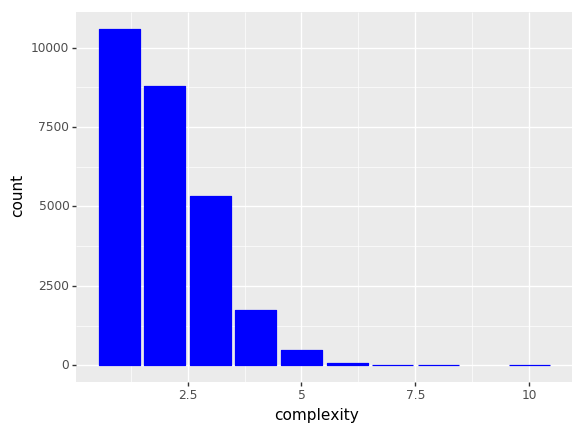

<ggplot: (7536755727)>

In [17]:
## complexity:
ggplot(dat_raw, aes(x = 'complexity')) + \
  geom_bar(color = 'blue', fill = 'blue')

### Multivariate exploration

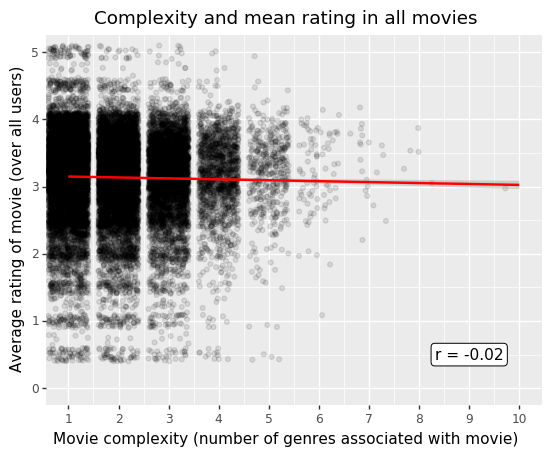

<ggplot: (-9223372029319082962)>


In [19]:
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## multivariate checks
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## plot complexity vs. average rating, using ggplot/plotnine:
cor_this = dat_raw[['rating_mean', 'complexity']].corr().iloc[0, 1]
p = ggplot(dat_raw, aes(y = 'rating_mean', x = 'complexity')) + \
  geom_jitter(height = 0.1, width = 0.4, alpha = .1, na_rm = True) + \
  geom_smooth(method = 'glm', color = 'red', na_rm = True) + \
  coord_cartesian(xlim = [1, 10],
                 ylim = [0, dat_raw['rating_mean'].max()]) + \
  scale_x_continuous(breaks = range(1, 11)) + \
  labs(
    title = 'Complexity and mean rating in all movies',
    x = 'Movie complexity (number of genres associated with movie)',
    y = 'Average rating of movie (over all users)'
  ) + \
  annotate(
    geom = 'label', x = 9, y = .5,
    label = 'r = {0:1.2f}'.format(cor_this)
  )
print(p)

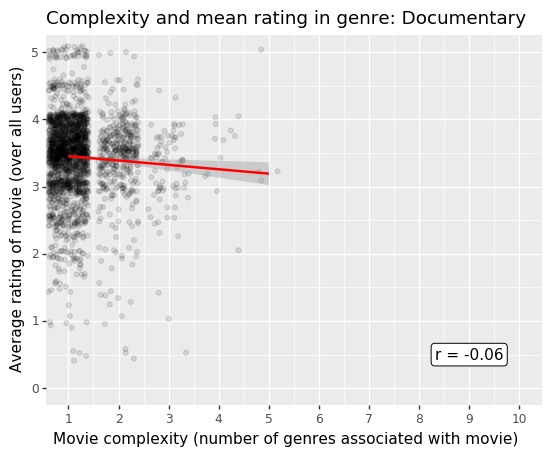

<ggplot: (-9223372029321425678)>


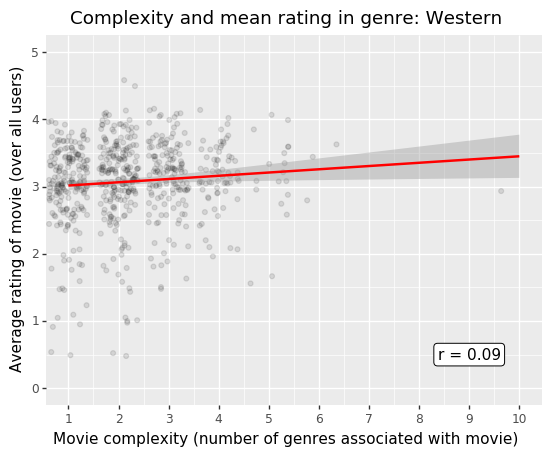

<ggplot: (7536657798)>


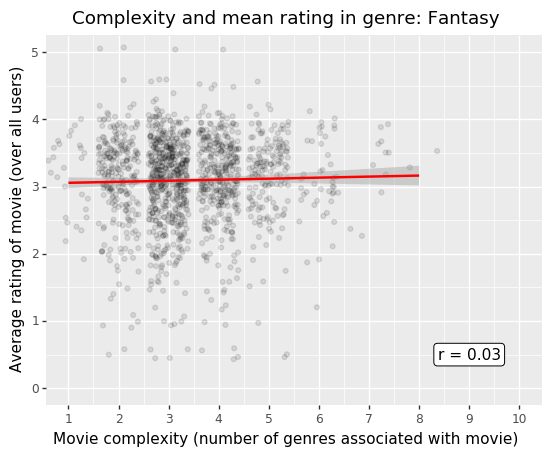

<ggplot: (-9223372029318116534)>


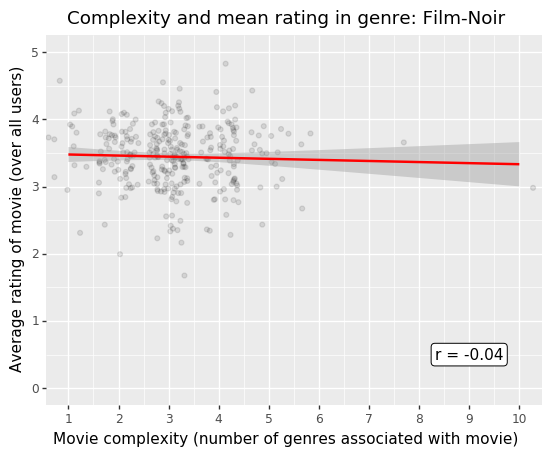

<ggplot: (7533408576)>


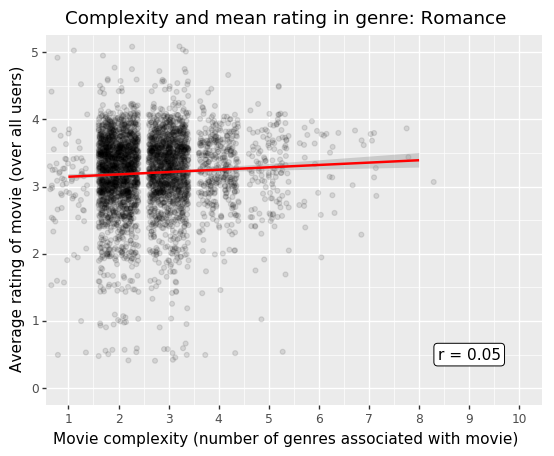

<ggplot: (7533369804)>


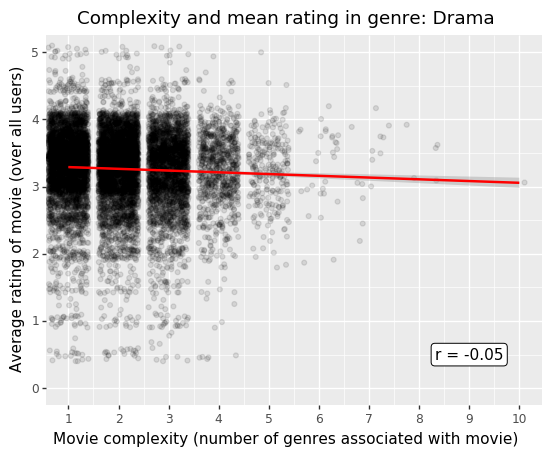

<ggplot: (-9223372029321641198)>


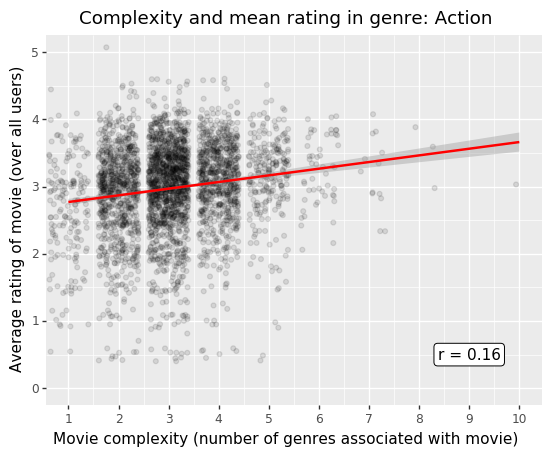

<ggplot: (-9223372029317966469)>


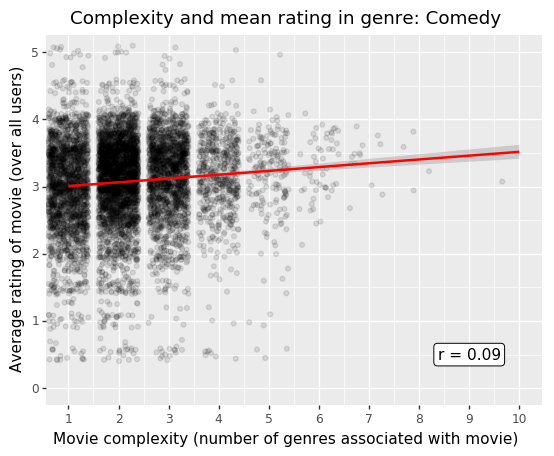

<ggplot: (7536752974)>


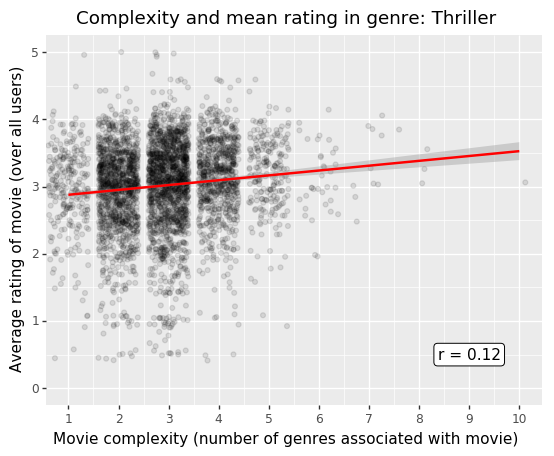

<ggplot: (-9223372029320024120)>


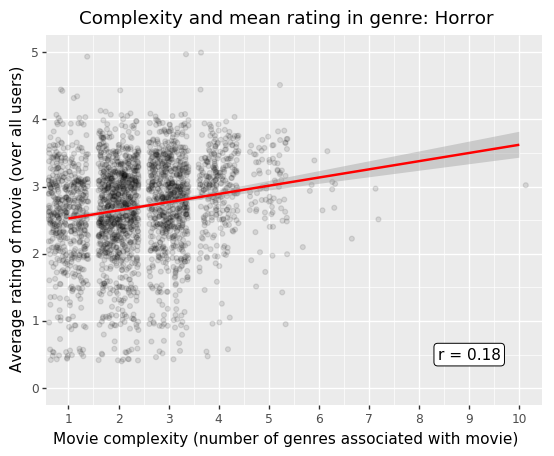

<ggplot: (-9223372029319821319)>


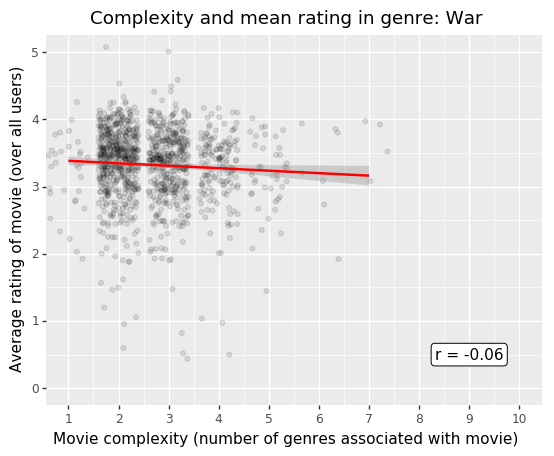

<ggplot: (7534832844)>


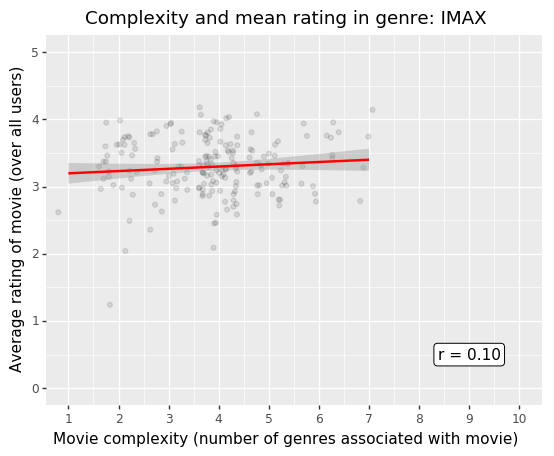

<ggplot: (7537791394)>


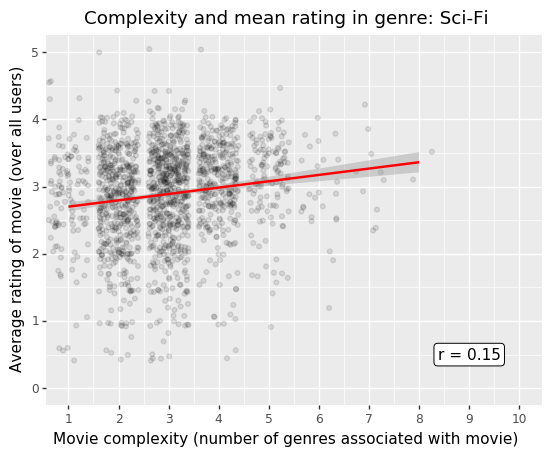

<ggplot: (-9223372029319208602)>


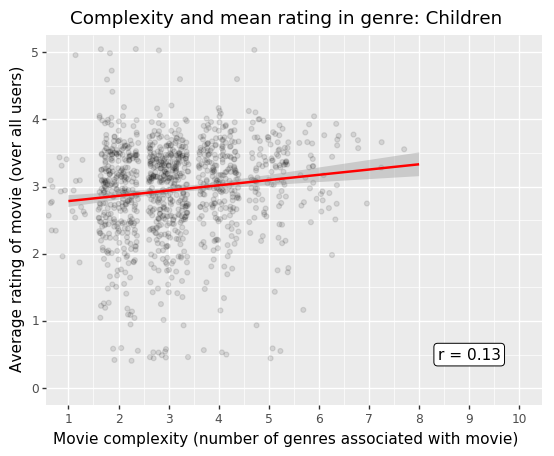

<ggplot: (-9223372029316981623)>


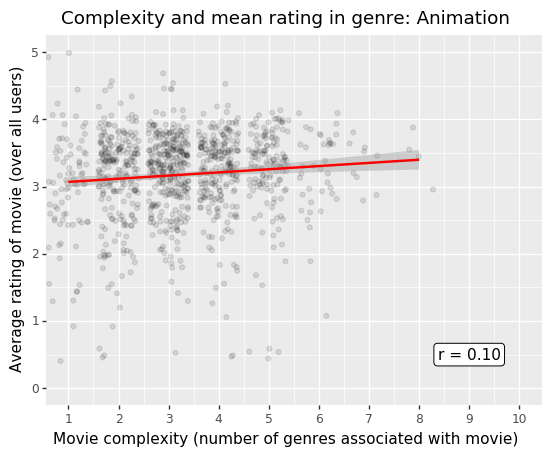

<ggplot: (-9223372029316504558)>


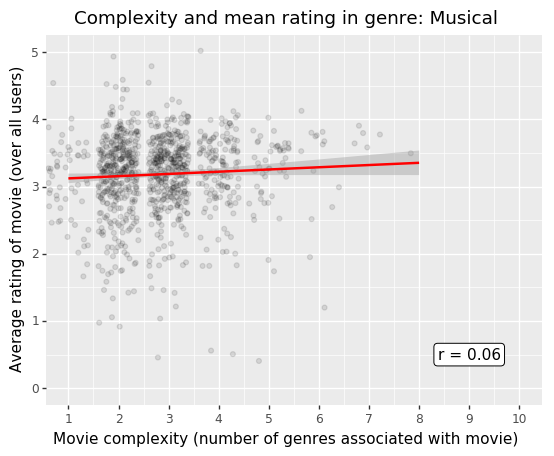

<ggplot: (-9223372029316981623)>


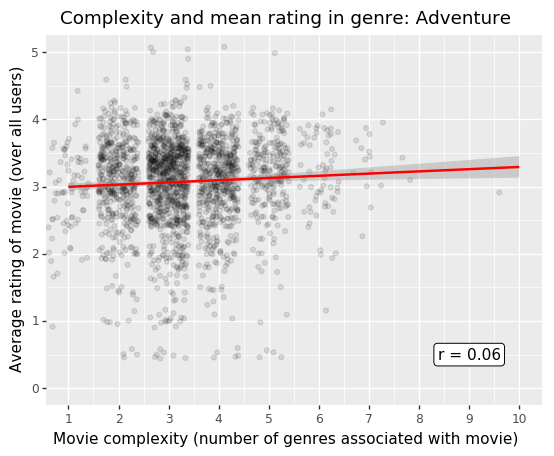

<ggplot: (-9223372029251163269)>


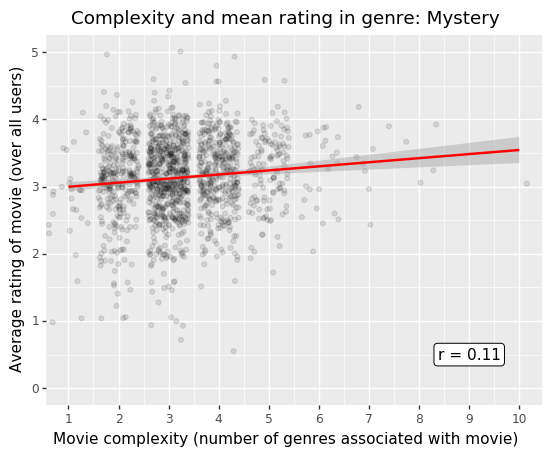

<ggplot: (-9223372029251151658)>


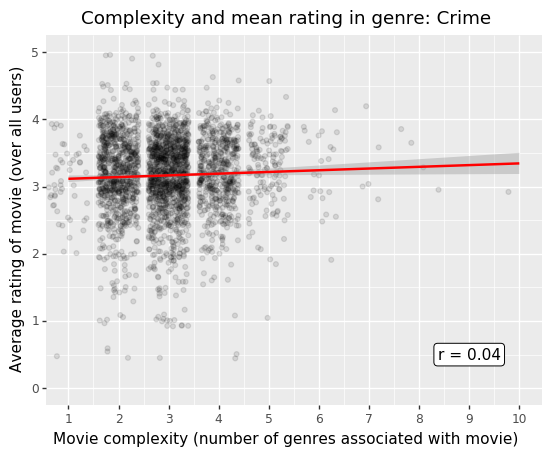

<ggplot: (7536446605)>


In [20]:
# ## plot complexity vs. average rating, within genre; using ggplot/plotnine:
genre_inds_plot = list(set(genre_inds) - set(['is_nogenreslisted']))
for i in genre_inds_plot:
    dat_this = dat_raw[dat_raw[i] == True]
    cor_this = dat_this[['rating_mean', 'complexity']].corr().iloc[0, 1]
    p = ggplot(dat_this, aes(y = 'rating_mean', x = 'complexity', )) + \
      geom_jitter(height = 0.1, width = 0.4, alpha = 0.1, na_rm = True) + \
      geom_smooth(method = 'glm', color = 'red', na_rm = True) + \
      coord_cartesian(xlim = [1, 10],
                     ylim = [0, dat_raw['rating_mean'].max()]) + \
      scale_x_continuous(breaks = range(1, 11)) + \
      labs(
        title = 'Complexity and mean rating in genre: {0}'.format(genre_dict[i]),
        x = 'Movie complexity (number of genres associated with movie)',
        y = 'Average rating of movie (over all users)'
      ) + \
      annotate(
        geom = 'label', x = 9, y = .5,
        label = 'r = {0:1.2f}'.format(cor_this)
      )
    print(p)


## Statistical Analysis

### Corrlations

In [21]:
## ========================================================================= ##
## Analysis
## ========================================================================= ##

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## correlation
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

dat_nona = dat_raw.dropna()

## np.corrcoef(dat_nona['rating_mean'], dat_nona['complexity'])
## AttributeError: 'float' object has no attribute 'shape'
## The error is reproducible if the array is of dtype=object

## correlation over all movies (using numpy):
np.corrcoef(dat_nona['rating_mean'], dat_nona['complexity'].astype(float))

## correlation over all movies (using pandas):
## (can handle missings, somehow)
dat_nona[['rating_mean', 'complexity']].corr()
dat_raw[['rating_mean', 'complexity']].corr()

## correlation within each movie category:
dat_cor = pd.DataFrame([])
for i in genre_inds:
    dat_this = dat_raw[dat_raw[i] == True]
    cor_this = dat_this[['rating_mean', 'complexity']].corr().iloc[0, 1]
    dat_cor = dat_cor.append(pd.DataFrame(
        {'Variable': i,
         'Genre'   : genre_dict[i],
         'n'       : dat_this.shape[0],
         'r'       : cor_this.round(3)}, 
        index = [0]))
    
dat_cor.sort_values(by = 'r', ascending = False)

,Variable,Genre,n,r
0,is_horror,Horror,2611,0.184
0,is_action,Action,3520,0.161
0,is_scifi,Sci-Fi,1743,0.150
0,is_children,Children,1139,0.128
0,is_thriller,Thriller,4178,0.118
0,is_mystery,Mystery,1514,0.108
0,is_animation,Animation,1027,0.097
0,is_imax,IMAX,196,0.096
0,is_comedy,Comedy,8374,0.092
0,is_western,Western,676,0.090
